# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

## 💡 Phage-Host-Features CSV Files

This notebook assumes that you already have the phage-host-features CSV files (from running [`5. Data Consolidation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/5.%20Data%20Consolidation.ipynb)).

Alternatively, you may download the CSV files from [Google Drive](https://drive.google.com/drive/folders/1xNoA6dxkN4jzVNCg_7YNjdPZzl51Jo9M?usp=sharing) and save the downloaded `data` folder inside the `inphared` directory located in the same folder as this notebook. The folder structure should look like this:

`experiments` (parent folder of this notebook) <br> 
↳ `inphared` <br>
&nbsp; &nbsp;↳ `data` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp_embeddings_esm.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
↳ `6.1. Further Model Evaluation (Specificity + PR Curve).ipynb` (this notebook) <br>

<hr>

## Part I: Preliminaries

Import the necessary libraries and modules.

In [1]:
import math
import pickle
import os
import warnings

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from imblearn.metrics import specificity_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc

from ConstantsUtil import ConstantsUtil
from ClassificationUtil import ClassificationUtil
import boeckaerts as RBP_f

%load_ext autoreload
%autoreload 2

C:\Users\Edward\anaconda3\lib\site-packages\Bio\SubsMat\__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

pd.options.mode.chained_assignment = None

with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
constants = ConstantsUtil()
util = ClassificationUtil()

<hr>

## Part II: Measuring Specificity

Load the pickled files storing the results of evaluating the performance of the models.

In [4]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

Declare constant variables for readability of subsequent code.

In [5]:
CLASS = 0
MICRO = 1
MACRO = 2
WEIGHTED = 3

PRECISION = 0
RECALL = 1

Y_TEST = -3
Y_PRED = -1

The shaded cells in the subsequent tables correspond to the highest scores (i.e., best performance in terms of the specified evaluation metric).

### Protein Language Models vs Handcrafted

In [6]:
results = []
for model in models:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[models.index(model)][threshold][Y_TEST]
        y_pred = model_results[models.index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)

print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = models)
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
PROTTRANSBERT,96.89%,96.78%,96.34%,95.83%,95.31%,94.78%,94.08%,93.36%,92.59%,91.64%,89.91%
PROTXLNET,96.82%,96.62%,96.12%,95.64%,95.20%,94.67%,94.04%,93.26%,92.50%,91.52%,89.85%
PROTTRANSALBERT,96.84%,96.76%,96.22%,95.68%,95.20%,94.70%,94.08%,93.30%,92.50%,91.57%,89.82%
PROTT5,97.26%,97.14%,96.60%,96.12%,95.61%,95.08%,94.44%,93.66%,92.93%,91.87%,89.93%
ESM,97.20%,97.00%,96.49%,96.02%,95.54%,95.05%,94.33%,93.60%,92.83%,91.82%,89.96%
ESM1B,97.33%,97.07%,96.61%,96.07%,95.57%,95.01%,94.35%,93.60%,92.83%,91.81%,89.94%
SEQVEC,96.63%,96.65%,96.19%,95.71%,95.24%,94.73%,94.06%,93.29%,92.56%,91.56%,89.76%
BOECKAERTS,96.76%,96.81%,96.32%,95.77%,95.17%,94.58%,93.89%,93.10%,92.36%,91.41%,89.61%


In [7]:
print("Weighted Specificity per Class")
print("\n============\n")

for threshold in range(0, 11):
    print('Confidence threshold k:', str(threshold * 10) + '%')
    y_test = model_results[models.index(model)][threshold][Y_TEST]
    y_pred = model_results[models.index(model)][threshold][Y_PRED]
    
    print()
    print(specificity_score(y_test, y_pred, average=None))
    print("\n============\n")

Weighted Specificity per Class


Confidence threshold k: 0%

[1.         0.99987528 0.99962598 1.         1.         0.99140546
 1.         1.         0.99888572 0.99724725 0.99950562 0.99888641
 0.99740484 0.99938119 0.99975198 1.         0.99360421 0.99975208
 0.99144317 0.84342472 0.99962816 0.99764356 0.9977786  1.
 0.98821091 0.99975327 0.99975287 0.999002   1.         0.99975272
 0.99950513 0.99656838 1.         0.99962963 0.9992542  0.99826797
 1.         0.99913194 0.99938088 0.99975309 1.         0.95107195
 0.99987615 1.         0.99875653 0.9996288  1.         0.99171566
 0.99862826 1.         0.99598645 0.98716972 0.99975232 0.99900436
 0.99900904 0.98788677 0.98353587 0.9992554  0.99638539]


Confidence threshold k: 10%

[1.         1.         0.99975065 1.         1.         0.99747219
 1.         1.         0.99975238 0.99887387 1.         0.99938134
 0.99777558 0.99950495 1.         1.         0.99586155 0.99975208
 0.99821201 0.94311685 1.         0.99975195 0.99814883

### Global: ProtT5 + Handcrafted (Individually)

In [8]:
model_results = []
important_features = ['A_freq', 'GC', 'C_freq', 'TTA', 'TTA_b']
for model in important_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [9]:
results = []
for model in important_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
A_freq,97.38%,97.20%,96.67%,96.17%,95.70%,95.17%,94.51%,93.76%,93.00%,91.90%,89.93%
GC,97.31%,97.21%,96.70%,96.21%,95.72%,95.21%,94.57%,93.80%,93.01%,91.97%,90.01%
C_freq,97.27%,97.18%,96.73%,96.21%,95.74%,95.24%,94.53%,93.78%,92.99%,91.92%,89.95%
TTA,97.31%,97.13%,96.60%,96.13%,95.64%,95.13%,94.48%,93.67%,92.90%,91.87%,89.94%
TTA_b,97.28%,97.13%,96.62%,96.14%,95.60%,95.12%,94.47%,93.67%,92.89%,91.86%,89.92%


### Protein Features Only: ProtT5 + Handcrafted (Individually)

In [10]:
model_results = []
important_protein_features = ['K', 'pI', 'Z4', 'CTDC2', 'mol_weight']
for model in important_protein_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [11]:
results = []
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_protein_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_protein_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_protein_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
K,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
pI,97.20%,97.13%,96.60%,96.13%,95.61%,95.09%,94.43%,93.63%,92.91%,91.86%,89.98%
Z4,97.18%,97.13%,96.58%,96.14%,95.66%,95.11%,94.43%,93.64%,92.88%,91.87%,89.94%
CTDC2,97.20%,97.14%,96.62%,96.14%,95.63%,95.13%,94.42%,93.67%,92.90%,91.85%,89.99%
mol_weight,97.22%,97.12%,96.58%,96.14%,95.65%,95.07%,94.45%,93.68%,92.91%,91.85%,89.96%


### Global: ProtT5 + Handcrafted (Top n)

In [12]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [13]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')

    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.38%,97.20%,96.67%,96.17%,95.70%,95.17%,94.51%,93.76%,93.00%,91.90%,89.93%
2,97.36%,97.20%,96.75%,96.27%,95.75%,95.28%,94.61%,93.83%,93.01%,91.94%,89.96%
3,97.37%,97.18%,96.72%,96.27%,95.76%,95.26%,94.60%,93.84%,93.03%,91.99%,89.96%
4,97.37%,97.23%,96.74%,96.26%,95.80%,95.30%,94.59%,93.83%,93.02%,91.96%,89.88%
5,97.37%,97.20%,96.74%,96.30%,95.78%,95.30%,94.59%,93.81%,93.03%,91.99%,89.93%


### Protein Features Only: ProtT5 + Handcrafted (Top n)

In [14]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_protein_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [15]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)

        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
2,97.27%,97.17%,96.63%,96.13%,95.65%,95.09%,94.45%,93.67%,92.91%,91.86%,89.96%
3,97.19%,97.14%,96.63%,96.14%,95.61%,95.11%,94.44%,93.65%,92.86%,91.87%,89.97%
4,97.19%,97.14%,96.62%,96.17%,95.66%,95.11%,94.45%,93.67%,92.90%,91.91%,89.98%
5,97.22%,97.09%,96.64%,96.14%,95.62%,95.10%,94.41%,93.69%,92.92%,91.86%,89.92%


<hr>

## Part II: Plotting the PR Curve

### Protein Language Models vs Handcrafted

In [17]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

In [18]:
results_precision = []
for model in models:
    result = []
    for threshold in range(0, 11):
        metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
results_recall = []
for model in models:
    result = []
    for threshold in range(0, 11):
        metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

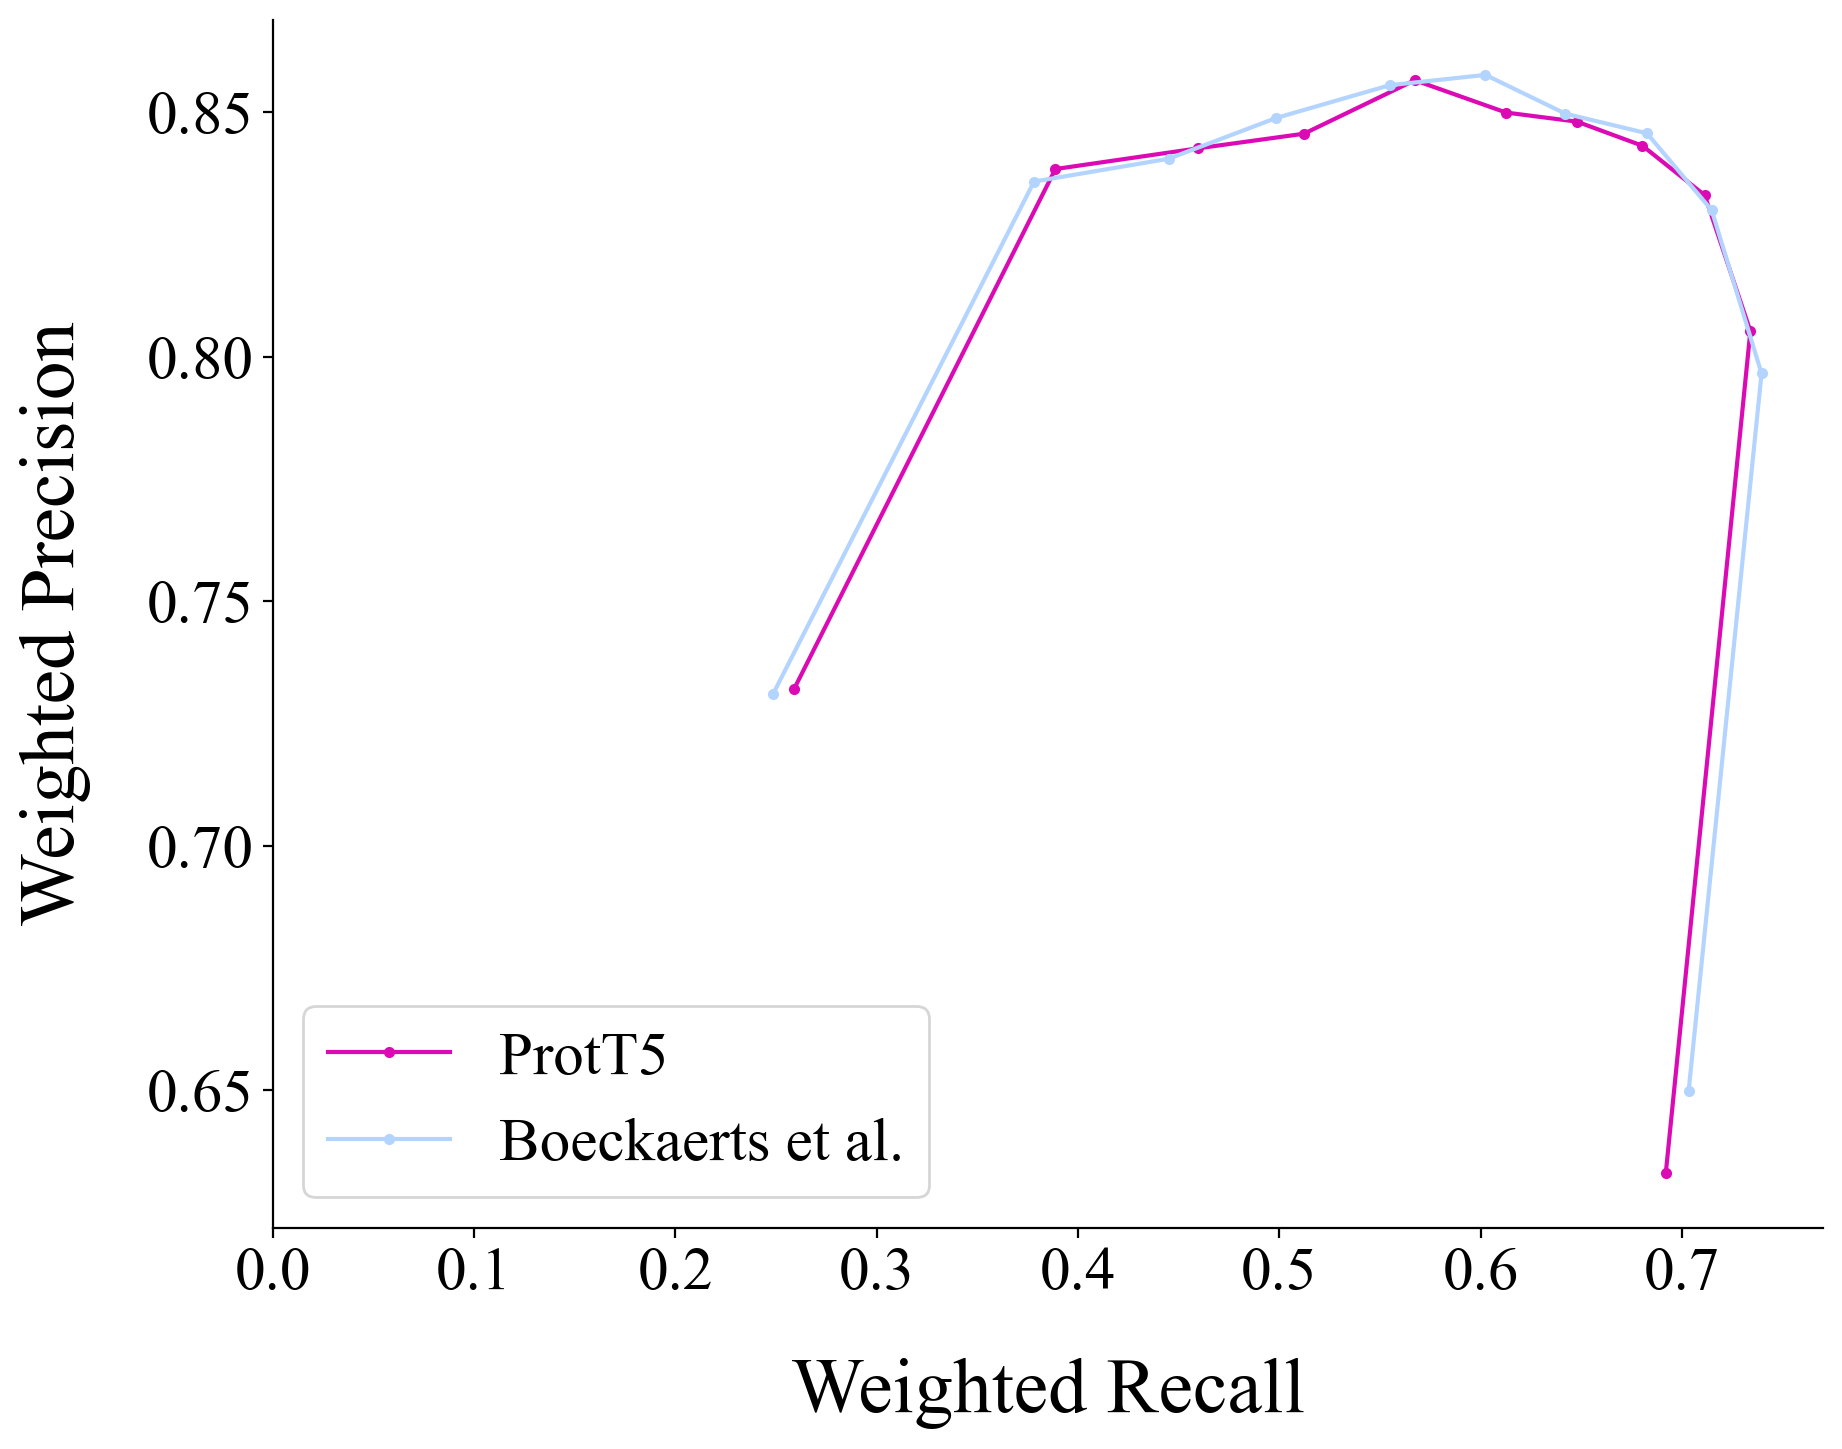

In [22]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
for i in range(0, len(models)):
    if i == len(models) - 2 or i == len(models) - 1:
        ax.plot(results_recall[i], results_precision[i], color = colors[i], marker = '.')
        ax.set_xlim(xmin=0, xmax=0.77)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend([ 
           'ProtT5', 
           'Boeckaerts et al.'], loc = 'lower left')

### Global: ProtT5 + Handcrafted (Individually)

In [22]:
for i in range(5):
    util.classify_handpicked_embeddings_more_thresholds([important_features[i]], important_features[i])

Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...


In [23]:
models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

model_results = []
for model in models:
    with open(constants.PLM_RESULTS_MORE_THRESHOLDS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [24]:
model_results = []
for model in important_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}_more_thresholds.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [25]:
for model in important_features[:5]:
    result = []
    for threshold in range(0, 101):
        metric = model_results[important_features[:5].index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for model in important_features[:5]:
    result = []
    for threshold in range(0, 101):
        metric = model_results[important_features[:5].index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

In [26]:
for model, precision, recall in zip(['PROTT5'] + important_features[:5], results_precision, results_recall):
    precision.reverse()
    recall.reverse()
    
    ave_precision = 0
    for i in range(1, len(precision)):
        ave_precision += (recall[i] - recall[i - 1]) * precision[i]
        
    print(model, ave_precision)

PROTT5 0.3733790877326551
A_freq 0.3771008650348734
GC 0.3720422025213896
C_freq 0.37634852313824874
TTA 0.3750286063140896
TTA_b 0.37561757917189675


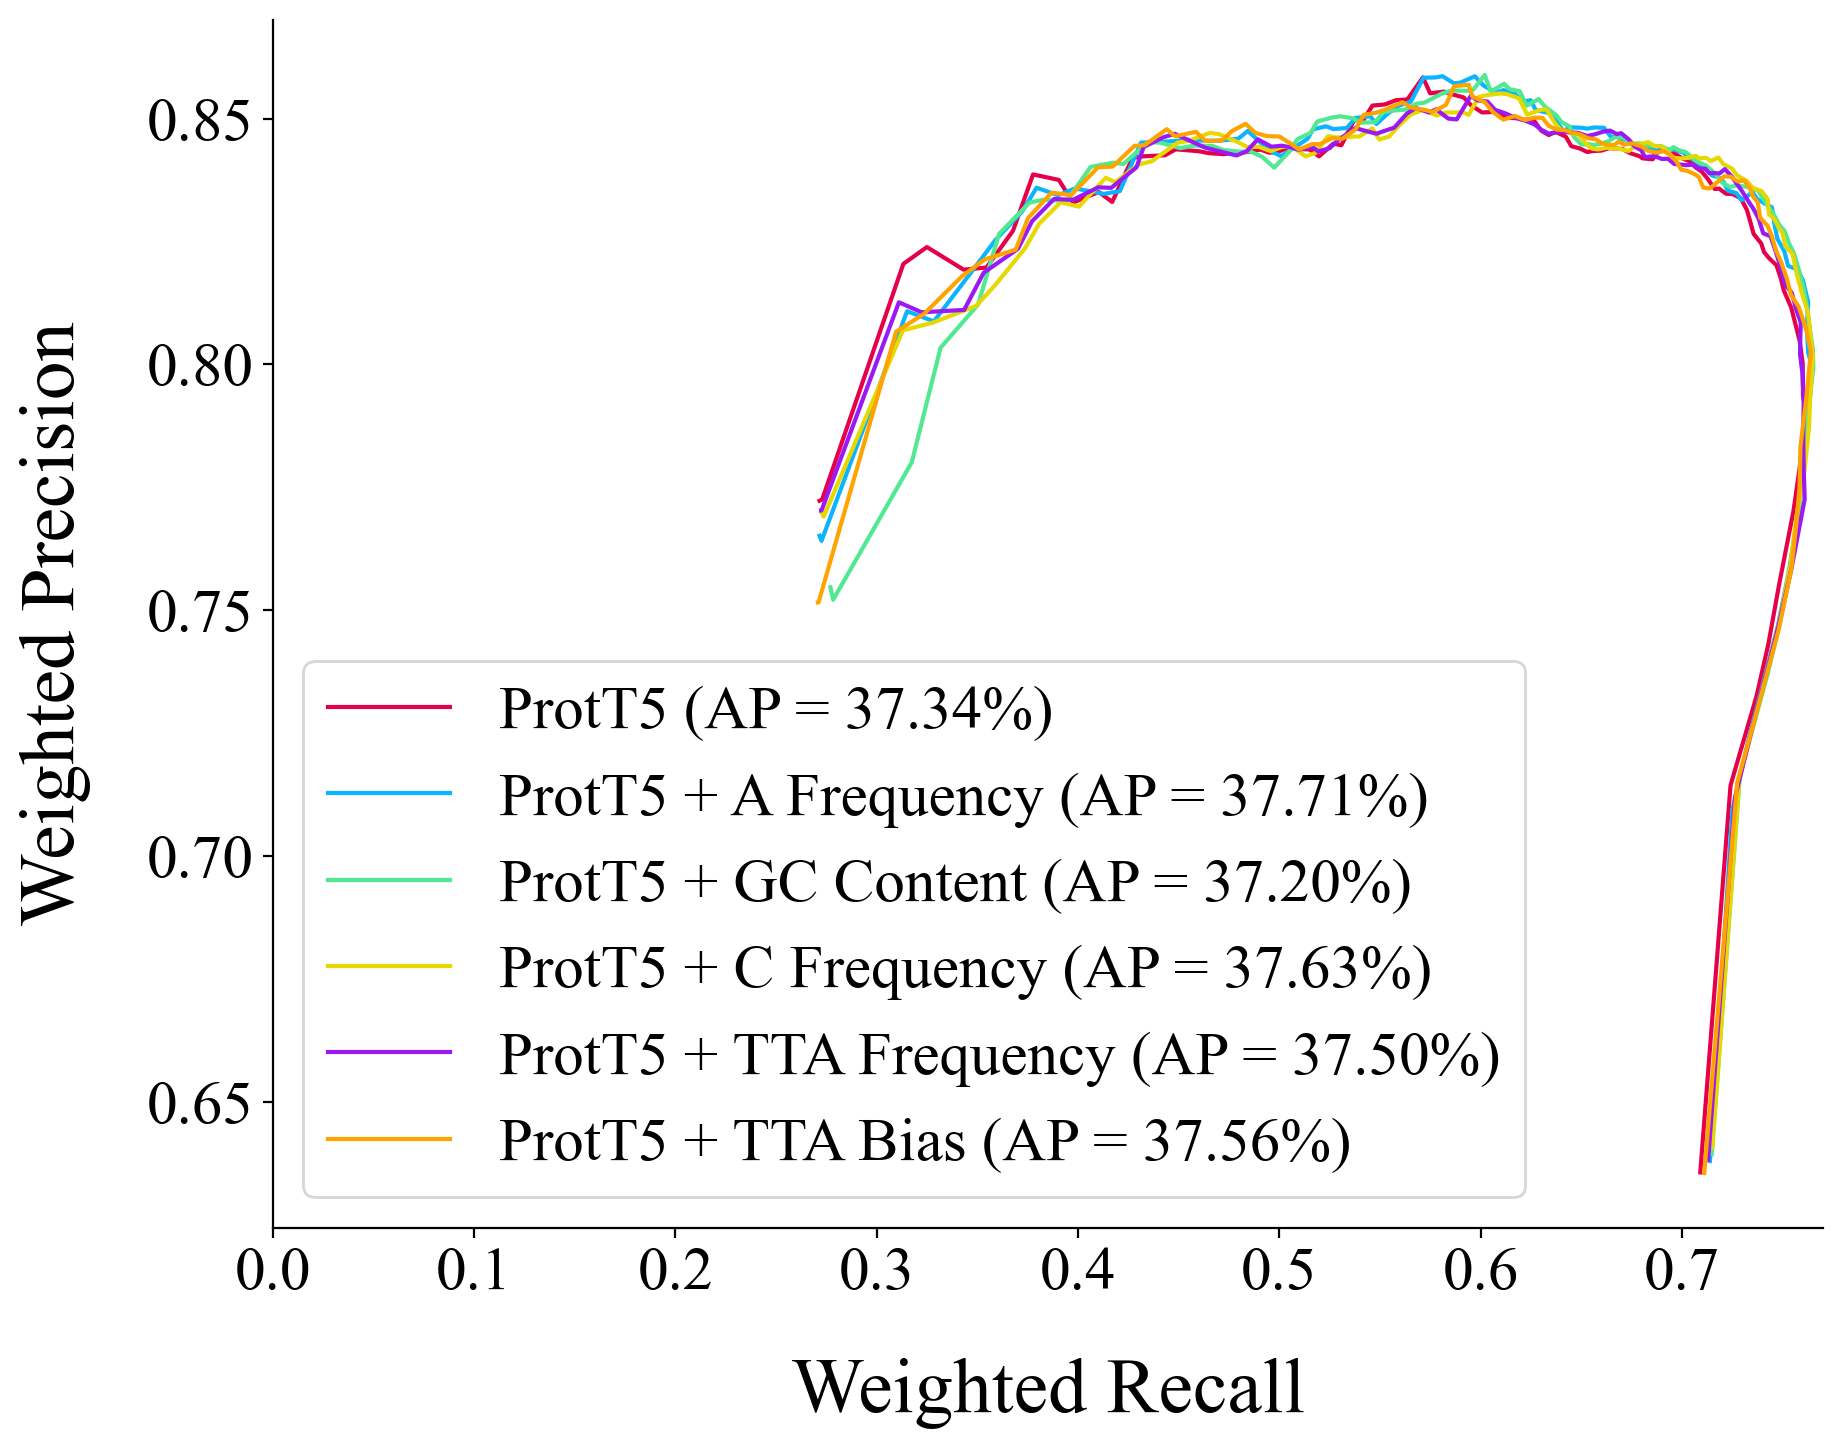

In [27]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
for i in range(0, 6):
    ax.plot(results_recall[i], results_precision[i], color = colors[i])
    ax.set_xlim(xmin=0, xmax=0.77)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(['ProtT5 (AP = 37.34%)',
           'ProtT5 + A Frequency (AP = 37.71%)', 
           'ProtT5 + GC Content (AP = 37.20%)', 
           'ProtT5 + C Frequency (AP = 37.63%)', 
           'ProtT5 + TTA Frequency (AP = 37.50%)', 
           'ProtT5 + TTA Bias (AP = 37.56%)'], loc = 'lower left')

### Protein Features Only: ProtT5 + Handcrafted (Individually)

In [28]:
for i in range(5):
    util.classify_handpicked_embeddings_more_thresholds([important_protein_features[i]], important_protein_features[i])

Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...


In [29]:
models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

model_results = []
for model in models:
    with open(constants.PLM_RESULTS_MORE_THRESHOLDS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [30]:
model_results = []
for model in important_protein_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}_more_thresholds.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [31]:
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 101):
        metric = model_results[important_protein_features[:5].index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 101):
        metric = model_results[important_protein_features[:5].index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

In [32]:
for model, precision, recall in zip(['PROTT5'] + important_protein_features[:5], results_precision, results_recall):
    precision.reverse()
    recall.reverse()
    
    ave_precision = 0
    for i in range(1, len(precision)):
        ave_precision += (recall[i] - recall[i - 1]) * precision[i]
        
    print(model, ave_precision)

PROTT5 0.3733790877326551
K 0.3724977327556101
pI 0.3704777945351539
Z4 0.3709170124348944
CTDC2 0.3689437006731498
mol_weight 0.3709810148928944


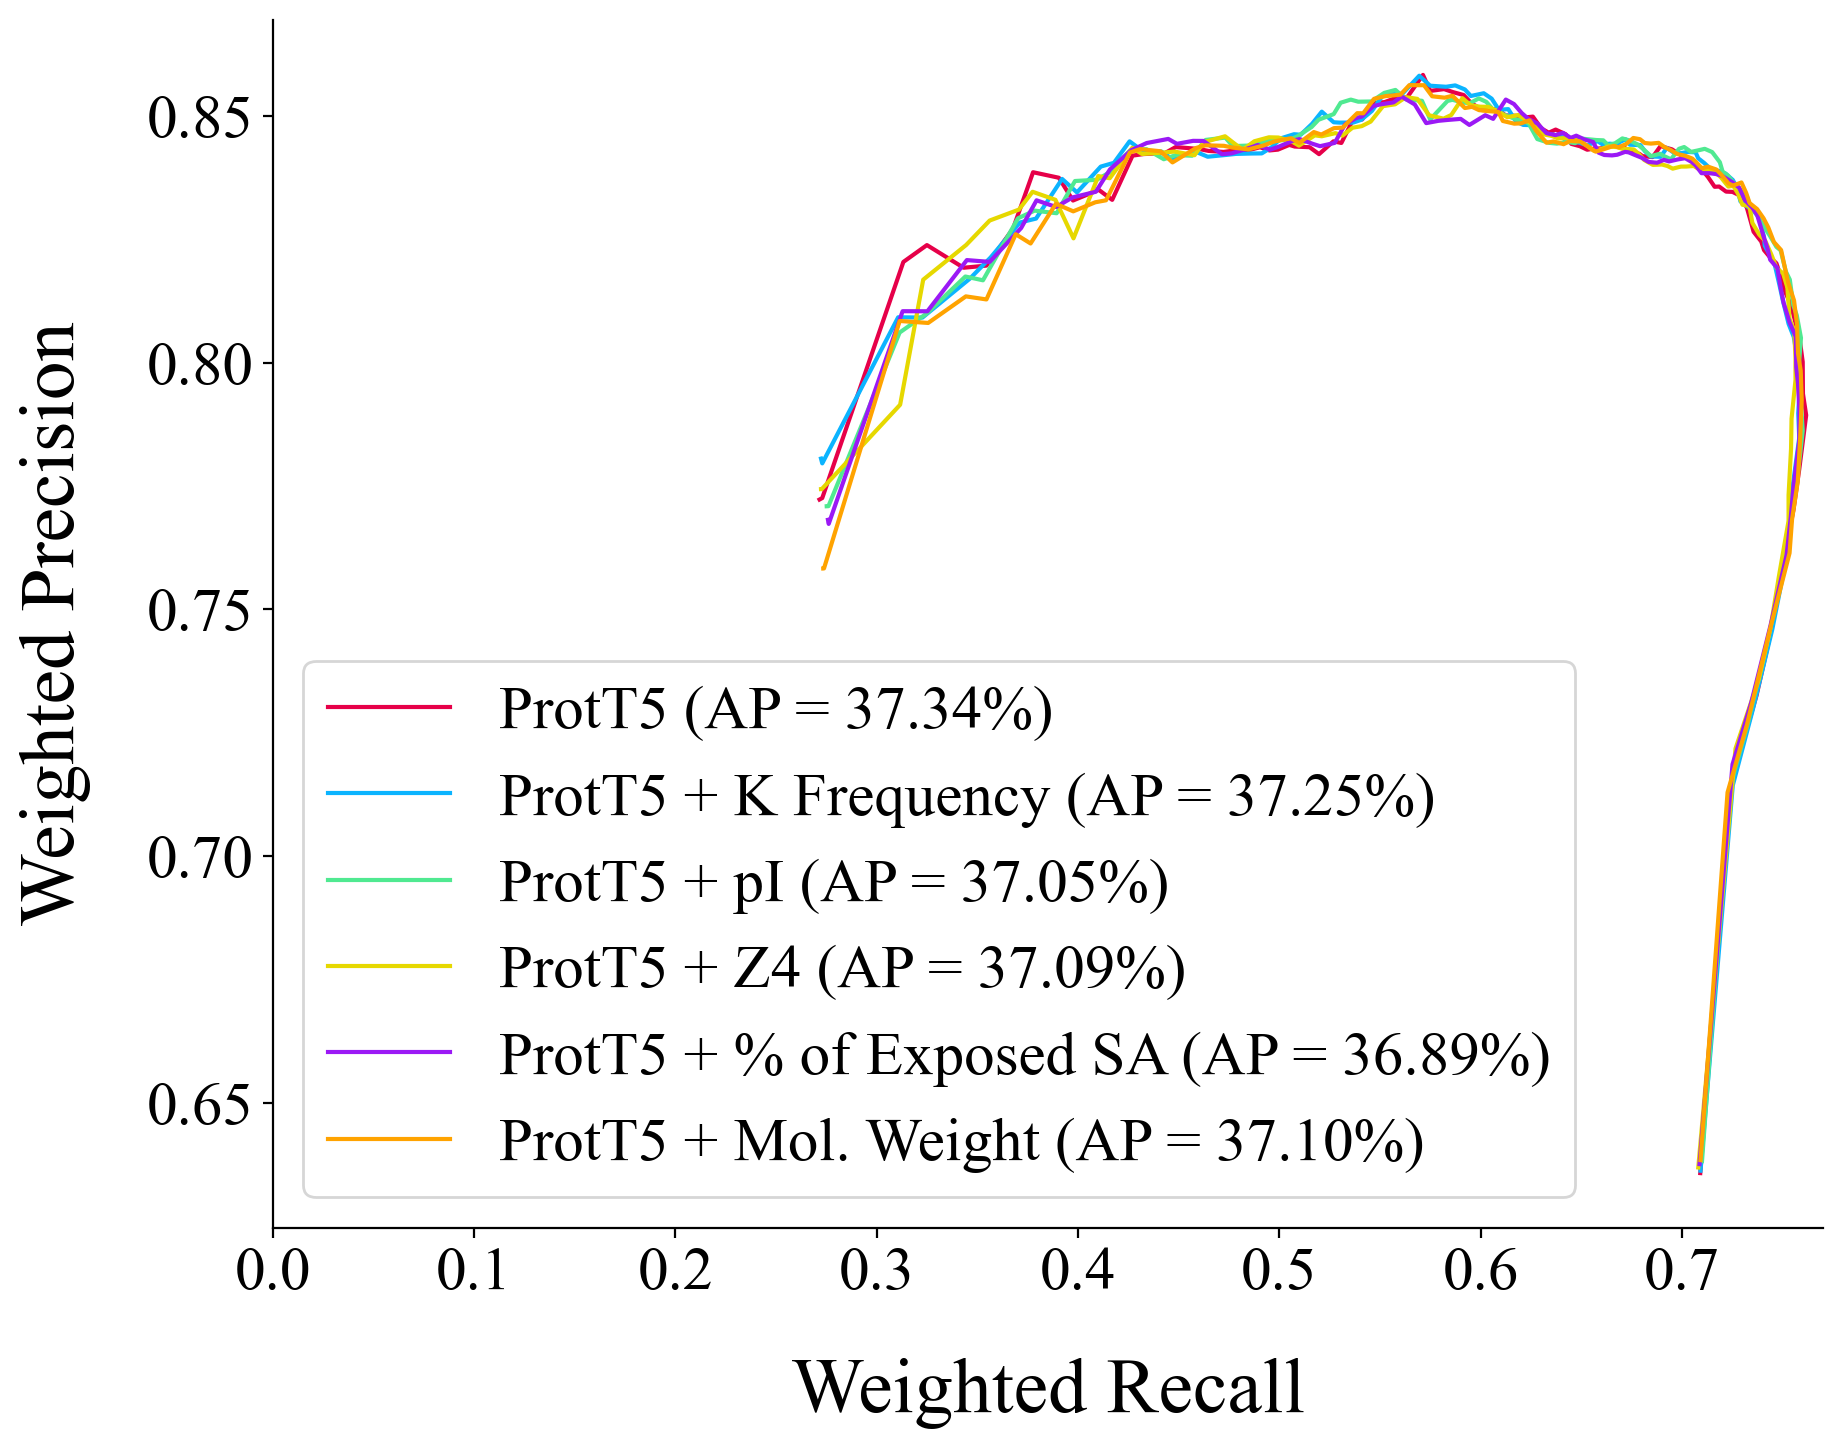

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
for i in range(0, 6):
    ax.plot(results_recall[i], results_precision[i], color = colors[i])
    ax.set_xlim(xmin=0, xmax=0.77)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(['ProtT5 (AP = 37.34%)',
           'ProtT5 + K Frequency (AP = 37.25%)', 
           'ProtT5 + pI (AP = 37.05%)', 
           'ProtT5 + Z4 (AP = 37.09%)', 
           'ProtT5 + % of Exposed SA (AP = 36.89%)', 
           'ProtT5 + Mol. Weight (AP = 37.10%)'], loc = 'lower left')

### Global: ProtT5 + Handcrafted (Top n)

In [34]:
for i in range(1, 6):
    util.classify_handpicked_embeddings_more_thresholds(important_features[:i], f'handcrafted_{i}')

Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...


In [35]:
models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

model_results = []
for model in models:
    with open(constants.PLM_RESULTS_MORE_THRESHOLDS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [36]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_{i}_more_thresholds.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [37]:
for i in range(0, 5):
    result = []
    for threshold in range(0, 101):
        metric = model_results[i][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for i in range(0, 5):
    result = []
    for threshold in range(0, 101):
        metric = model_results[i][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

In [38]:
for model, precision, recall in zip(['PROTT5'] + [_ for _ in range(1, 6)], results_precision, results_recall):
    precision.reverse()
    recall.reverse()
    
    ave_precision = 0
    for i in range(1, len(precision)):
        ave_precision += (recall[i] - recall[i - 1]) * precision[i]
        
    print(model, ave_precision)

PROTT5 0.3733790877326551
1 0.3771008650348734
2 0.37927802210707834
3 0.37889470660207086
4 0.3829079421505955
5 0.38347031087755984


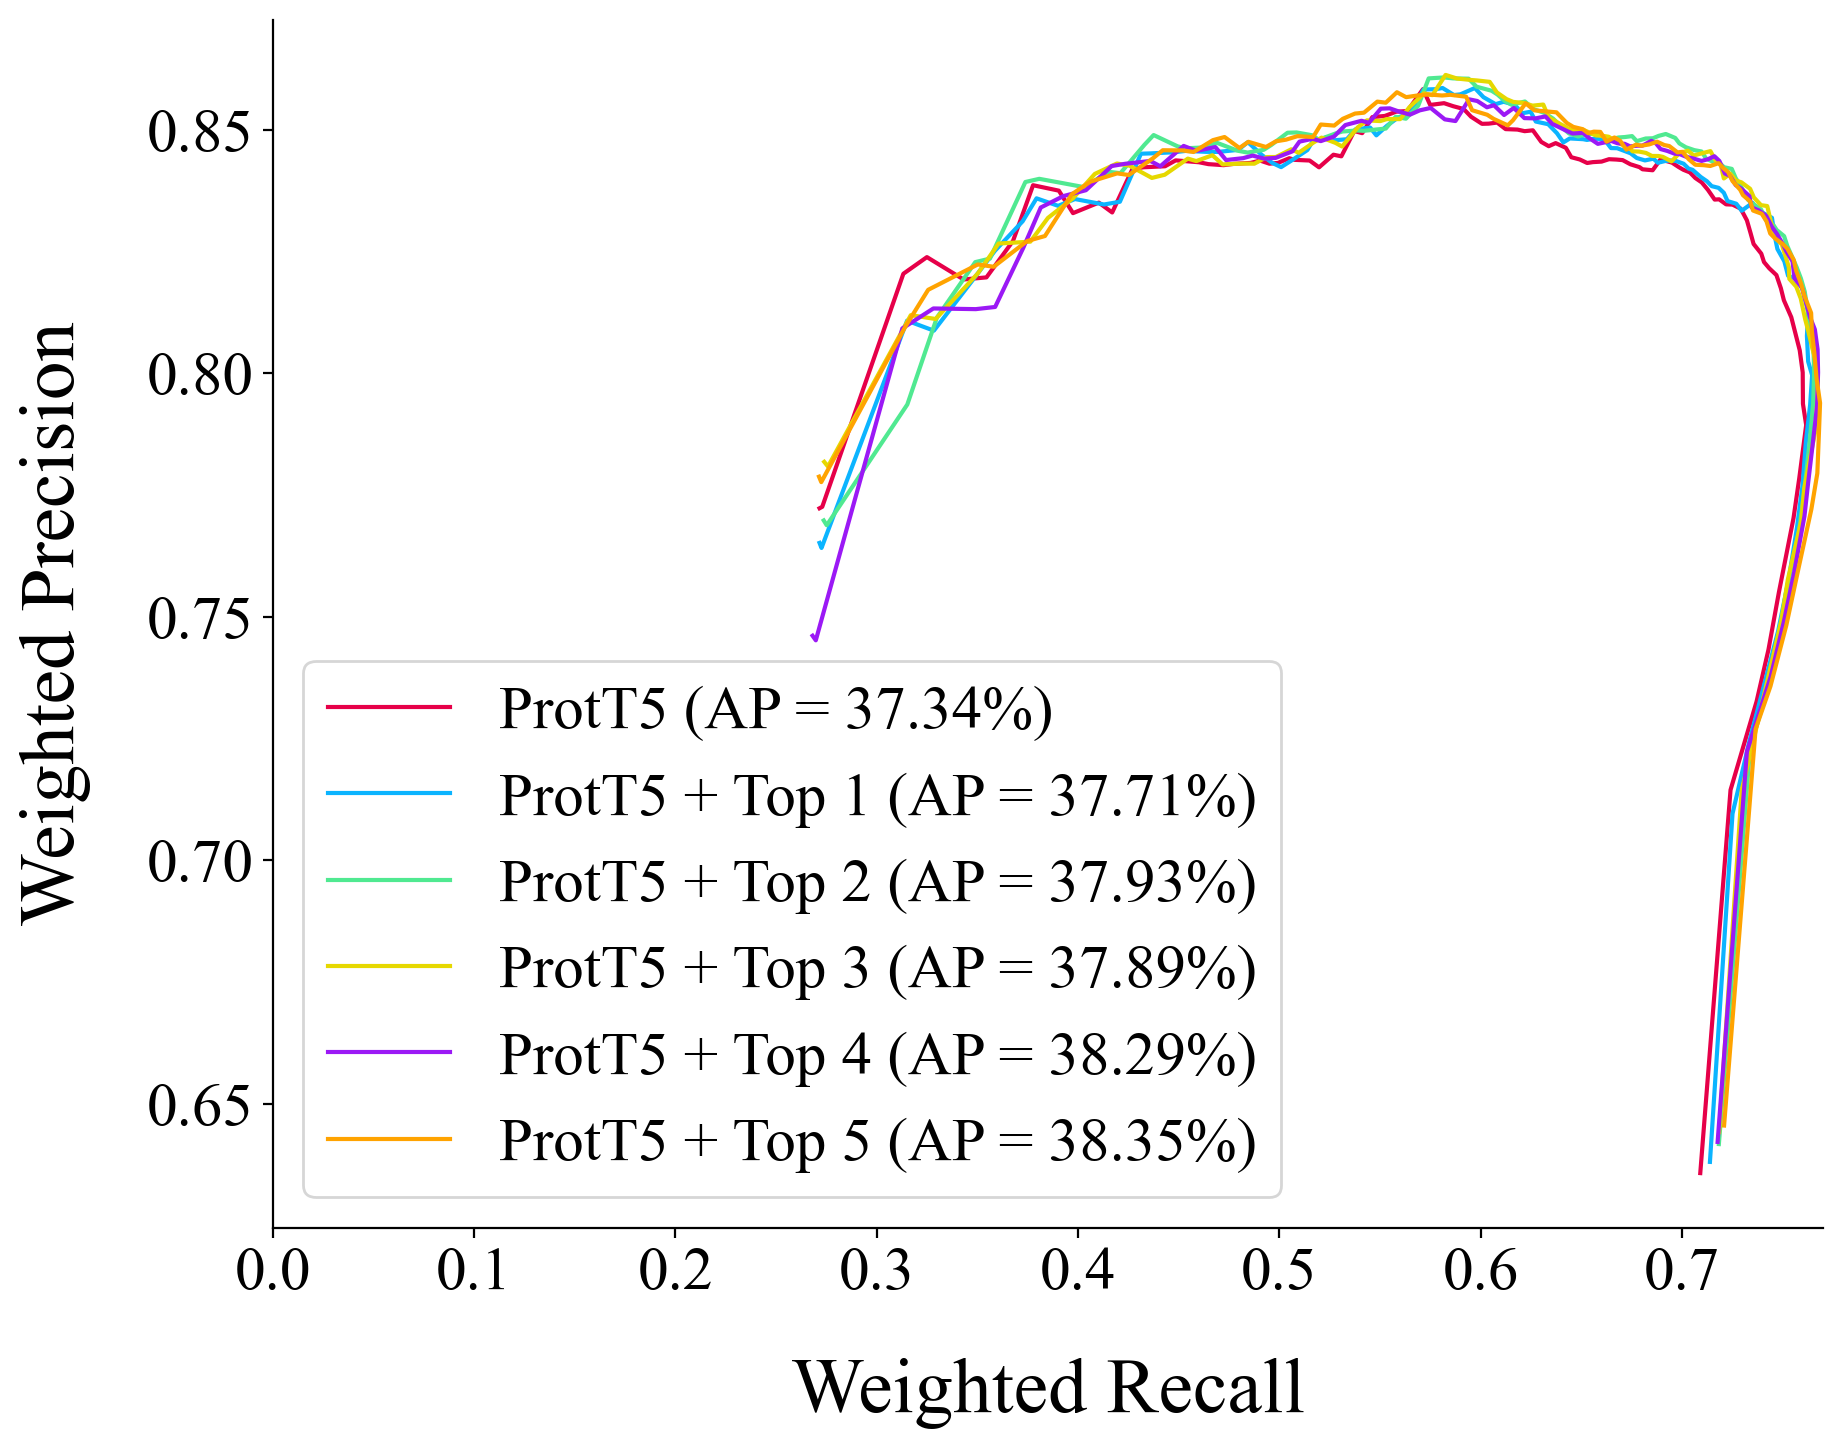

In [39]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
for i in range(0, 6):
    ax.plot(results_recall[i], results_precision[i], color = colors[i])
    ax.set_xlim(xmin=0, xmax=0.77)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(['ProtT5 (AP = 37.34%)',
           'ProtT5 + Top 1 (AP = 37.71%)', 
           'ProtT5 + Top 2 (AP = 37.93%)', 
           'ProtT5 + Top 3 (AP = 37.89%)', 
           'ProtT5 + Top 4 (AP = 38.29%)', 
           'ProtT5 + Top 5 (AP = 38.35%)'], loc = 'lower left')

### Protein Features Only: ProtT5 + Handcrafted (Top n)

In [40]:
for i in range(1, 6):
    util.classify_handpicked_embeddings_more_thresholds(important_protein_features[:i], f'handcrafted_protein_{i}')

Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...
Constructing training and test sets...
Training the model...
Saving evaluation results...


In [41]:
models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

model_results = []
for model in models:
    with open(constants.PLM_RESULTS_MORE_THRESHOLDS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 101):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [42]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_protein_{i}_more_thresholds.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [43]:
for i in range(0, 5):
    result = []
    for threshold in range(0, 101):
        metric = model_results[i][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for i in range(0, 5):
    result = []
    for threshold in range(0, 101):
        metric = model_results[i][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

In [44]:
for model, precision, recall in zip(['PROTT5'] + [_ for _ in range(1, 6)], results_precision, results_recall):
    precision.reverse()
    recall.reverse()
    
    ave_precision = 0
    for i in range(1, len(precision)):
        ave_precision += (recall[i] - recall[i - 1]) * precision[i]
        
    print(model, ave_precision)

PROTT5 0.3733790877326551
1 0.3724977327556101
2 0.3704125246296872
3 0.3714178214006497
4 0.3705579835679844
5 0.3723717549480697


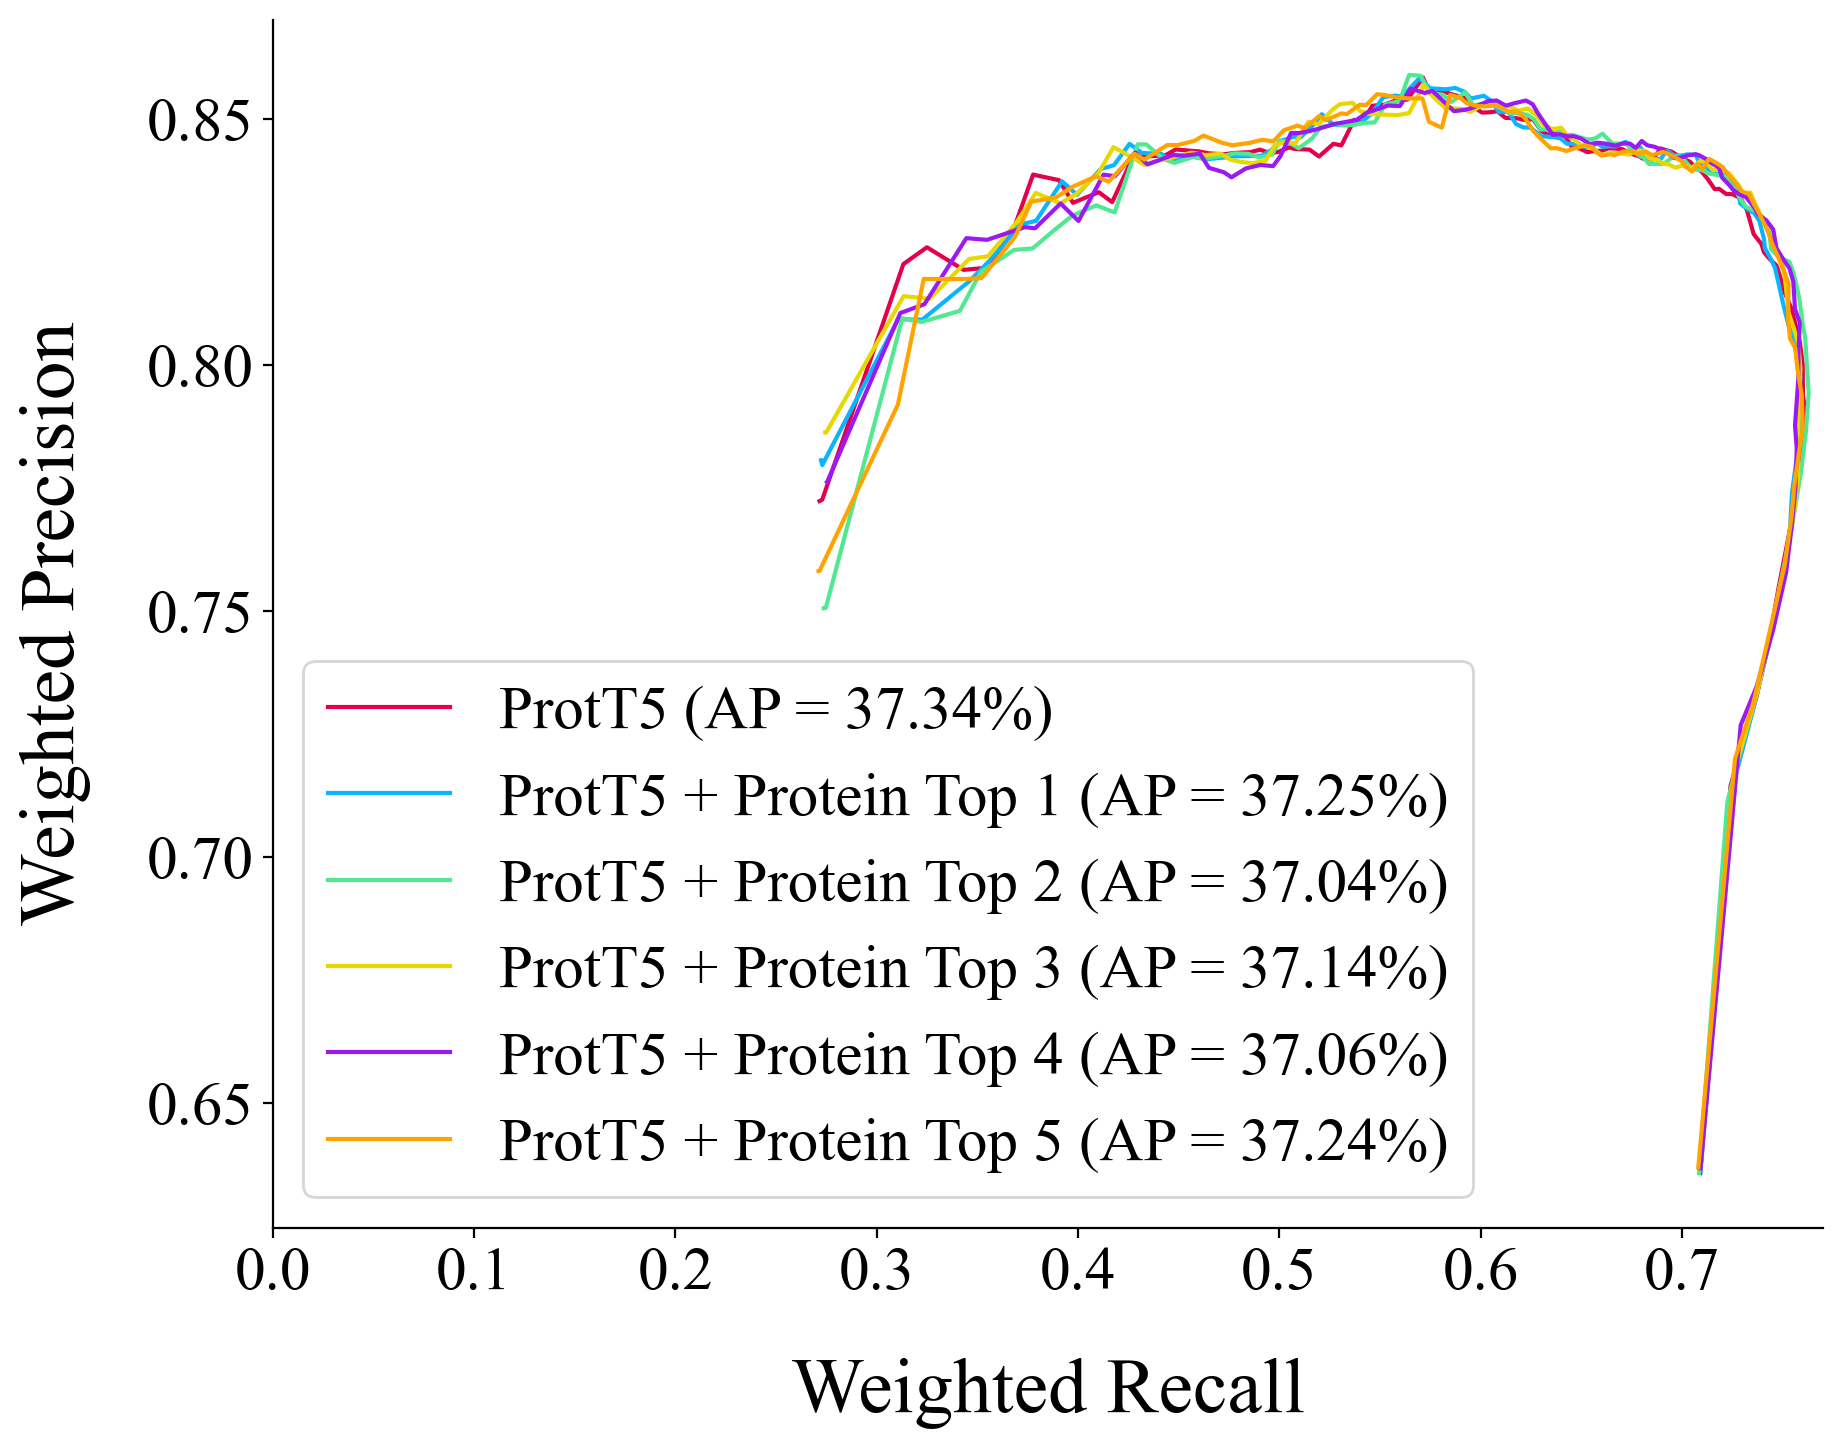

In [45]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
for i in range(0, 6):
    ax.plot(results_recall[i], results_precision[i], color = colors[i])
    ax.set_xlim(xmin=0, xmax=0.77)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(['ProtT5 (AP = 37.34%)',
           'ProtT5 + Protein Top 1 (AP = 37.25%)', 
           'ProtT5 + Protein Top 2 (AP = 37.04%)', 
           'ProtT5 + Protein Top 3 (AP = 37.14%)', 
           'ProtT5 + Protein Top 4 (AP = 37.06%)', 
           'ProtT5 + Protein Top 5 (AP = 37.24%)'], loc = 'lower left')